Model training, hyper-parameter tuning and cross-validation

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [215]:
# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

Screening questionnaire (feature selection)

In [216]:
# load the screening questionnaire 
#screening_questions = pd.read_csv('screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('10_screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('15_screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('20_screening_questions.csv', sep=';')
screening_questions = pd.read_csv('25_screening_questions.csv', sep=';')
screening_questions

,Critère DSM-5,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
0,A,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention
1,A,I have been accused of inaccuracies in my work,tr2,Often fails to give close attention to details...,inattention
2,A,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention
3,B,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
4,C,My relatives blame me for not listening to the...,tr7,Often does not seem to listen when spoken to d...,inattention
5,C,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention
6,D,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention
7,D,"I have difficulty completing my tasks (work, h...",tr10,Often does not follow through on instructions ...,inattention
8,E,I have difficulty organizing my time,tr12,Often has difficulty organizing tasks and acti...,inattention
9,E,It is difficult for me to organize tasks that ...,tr14,Often has difficulty organizing tasks and acti...,inattention


Data preprocessing

In [217]:
adasyn = ADASYN(random_state=38)
X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
balanced_df.describe()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.457865,3.542135,3.702247,4.794944,4.379213,3.870787,3.735955,3.292135,4.308989,...,1.553371,1.390449,1.294944,0.988764,0.761236,1.415730,1.595506,1.109551,1.033708,1.176966
std,0.500696,0.498923,1.587245,1.536814,1.430090,1.470658,1.581634,1.652297,1.693083,1.622041,...,1.020889,0.879705,0.961265,0.987178,0.820005,1.027059,0.975406,1.043730,1.025857,1.071857
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


Split the balanced dataset by gender for train, test and validation sets

In [218]:
# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

# further filter the features to extract only the ones in the narrowed down version of the questionnaire
screening_qs_codes = screening_questions['question_code'].unique()
X_women = X_women.filter(items=screening_qs_codes, axis=1)
X_men = X_men.filter(items=screening_qs_codes, axis=1)


In [219]:
# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, stratify=y_women, random_state=15) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.35, stratify=y_train_val_women, random_state=15) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, stratify=y_men, random_state=15) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.35, stratify=y_train_val_men, random_state=15) 

Model training

In [220]:
# save results
def save_evaluation_results(model_name, gender, accuracy, precision, recall, f1, roc_auc, best_params=None):
    file_name = f"{model_name}_{gender}.txt"
    with open(file_name, 'w') as file:
        file.write(f'Evaluation metrics for {gender}:\n')
        file.write(f'Accuracy: {accuracy:.3f}\n')
        file.write(f'Precision: {precision:.3f}\n')
        file.write(f'Recall: {recall:.3f}\n')
        file.write(f'F1 Score: {f1:.3f}\n')
        file.write(f'ROC AUC Score: {roc_auc:.3f}\n')
        if best_params:
            file.write('\nBest Model Parameters:\n')
            for key, value in best_params.items():
                file.write(f'{key}: {value}\n')

def save_confusion_matrix_plot(conf_matrix, model_name, gender):
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} on {gender}')
    plt.savefig(f'confusion_matrix_{model_name}_{gender}.png')
    plt.close()

def save_cross_validation_results(model_name, gender, cv_results):
    file_name = f"{model_name}_{gender}_cross_validation.txt"
    with open(file_name, 'w') as file:
        file.write(f'Cross-Validation Results for {gender}:\n')
        
        file.write(f'Accuracy: {np.round(cv_results["test_accuracy"], 3)}\n')
        file.write(f'Precision: {np.round(cv_results["test_precision"], 3)}\n')
        file.write(f'Recall: {np.round(cv_results["test_recall"], 3)}\n')
        file.write(f'F1 Score: {np.round(cv_results["test_f1"], 3)}\n')
        file.write(f'ROC AUC Score: {np.round(cv_results["test_roc_auc"], 3)}\n')

        file.write(f'Mean CV Accuracy: {np.round(np.mean(cv_results["test_accuracy"]), 3)}\n')
        file.write(f'Mean CV Precision: {np.round(np.mean(cv_results["test_precision"]), 3)}\n')
        file.write(f'Mean CV Recall: {np.round(np.mean(cv_results["test_recall"]), 3)}\n')
        file.write(f'Mean CV F1 Score: {np.round(np.mean(cv_results["test_f1"]), 3)}\n')
        file.write(f'Mean CV ROC AUC Score: {np.round(np.mean(cv_results["test_roc_auc"]), 3)}\n')


In [221]:
def evaluate_model(model, X_val, y_val, gender, best_params=None):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)

    print(f'Evaluation metrics for {gender}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC Score: {roc_auc}')

    conf_matrix = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    disp.plot(cmap='Blues')

    # save evaluation metrics to a file
    save_evaluation_results(model.__class__.__name__, gender, accuracy, precision, recall, f1, roc_auc, best_params=best_params)

    # save confusion matrix plot as picture
    save_confusion_matrix_plot(conf_matrix, model.__class__.__name__, gender)

In [222]:
# 5-fold cross validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=15)

def cross_validation(model, X_train, y_train, gender, kf):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring)
    
    save_cross_validation_results(model.__class__.__name__, gender, cv_results)
    print("Cross-Validation Results:")
    
    print("Accuracy:", cv_results['test_accuracy'])
    print("Precision:", cv_results['test_precision'])
    print("Recall:", cv_results['test_recall'])
    print("F1 Score:", cv_results['test_f1'])
    print("ROC AUC Score:", cv_results['test_roc_auc'])

    print("Mean CV Accuracy:", np.mean(cv_results['test_accuracy']))
    print("Mean CV Precision:", np.mean(cv_results['test_precision']))
    print("Mean CV Recall:", np.mean(cv_results['test_recall']))
    print("Mean CV F1 Score:", np.mean(cv_results['test_f1']))
    print("Mean CV ROC AUC Score:", np.mean(cv_results['test_roc_auc']))

Logistic Regression

In [223]:
# define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # l1 lasso l2 ridge
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}

Logistic Regression for Women

In [224]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 0.5, 'penalty': 'l1'}


In [225]:
best_logistic_reg_women = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)
best_logistic_reg_women.fit(X_train_val_women, y_train_val_women)

LogisticRegression(C=0.5, max_iter=1000, penalty='l1', random_state=15,
                   solver='liblinear')

Evaluation metrics for women:
Accuracy: 0.8055555555555556
Precision: 0.8125
Recall: 0.7647058823529411
F1 Score: 0.787878787878788
ROC AUC Score: 0.8034055727554179


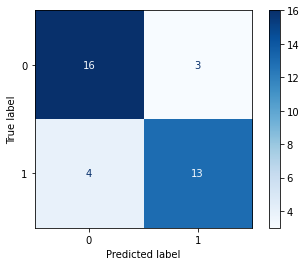

<Figure size 576x432 with 0 Axes>

In [226]:
evaluate_model(best_logistic_reg_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [227]:
cross_validation(best_logistic_reg_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.89655172 0.85714286 0.67857143 0.82142857 0.82142857]
Precision: [0.92857143 0.9        0.55       0.8125     0.86666667]
Recall: [0.86666667 0.75       1.         0.86666667 0.8125    ]
F1 Score: [0.89655172 0.81818182 0.70967742 0.83870968 0.83870968]
ROC AUC Score: [0.98095238 0.875      0.8342246  0.9025641  0.88541667]
Mean CV Accuracy: 0.8150246305418719
Mean CV Precision: 0.8115476190476191
Mean CV Recall: 0.8591666666666666
Mean CV F1 Score: 0.8203660633026596
Mean CV ROC AUC Score: 0.8956315498227262


In [228]:
# extract feature importances
#feature_importances = np.abs(best_logistic_reg.coef_).sum(axis=0)

#print("Feature Importances:")
#for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

Logistic Regression for Men

In [229]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 1, 'penalty': 'l1'}


In [230]:
best_logistic_reg_men = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)
best_logistic_reg_men.fit(X_train_val_men, y_train_val_men)

LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=15,
                   solver='liblinear')

Evaluation metrics for men:
Accuracy: 0.9722222222222222
Precision: 1.0
Recall: 0.9333333333333333
F1 Score: 0.9655172413793104
ROC AUC Score: 0.9666666666666667


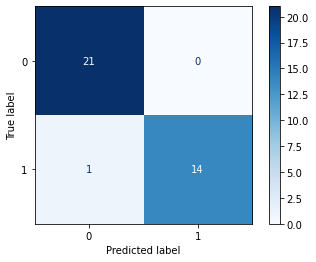

<Figure size 576x432 with 0 Axes>

In [231]:
evaluate_model(best_logistic_reg_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [232]:
cross_validation(best_logistic_reg_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [0.96551724 0.93103448 0.89655172 0.75       0.92857143]
Precision: [1.         0.86666667 0.8        0.65       0.92857143]
Recall: [0.9        1.         1.         1.         0.92857143]
F1 Score: [0.94736842 0.92857143 0.88888889 0.78787879 0.92857143]
ROC AUC Score: [0.95789474 0.89903846 0.98529412 0.84102564 0.99489796]
Mean CV Accuracy: 0.8943349753694582
Mean CV Precision: 0.849047619047619
Mean CV Recall: 0.9657142857142856
Mean CV F1 Score: 0.8962557909926332
Mean CV ROC AUC Score: 0.935630183247388


Random Forest

In [233]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

Random Forest for Women

In [234]:
rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}


In [235]:
best_rf_classifier_women = RandomForestClassifier(**best_params, random_state=15)
best_rf_classifier_women.fit(X_train_val_women, y_train_val_women)

RandomForestClassifier(min_samples_leaf=4, n_estimators=10, random_state=15)

Evaluation metrics for women:
Accuracy: 0.9166666666666666
Precision: 0.8888888888888888
Recall: 0.9411764705882353
F1 Score: 0.9142857142857143
ROC AUC Score: 0.9179566563467493


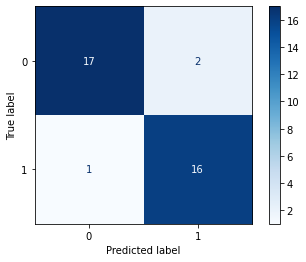

<Figure size 576x432 with 0 Axes>

In [236]:
evaluate_model(best_rf_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [237]:
cross_validation(best_rf_classifier_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.86206897 0.89285714 0.67857143 0.85714286 0.78571429]
Precision: [0.92307692 0.90909091 0.55       0.86666667 0.85714286]
Recall: [0.8        0.83333333 1.         0.86666667 0.75      ]
F1 Score: [0.85714286 0.86956522 0.70967742 0.86666667 0.8       ]
ROC AUC Score: [0.94761905 0.93229167 0.9171123  0.9025641  0.91666667]
Mean CV Accuracy: 0.8152709359605913
Mean CV Precision: 0.8211954711954712
Mean CV Recall: 0.85
Mean CV F1 Score: 0.8206104321111335
Mean CV ROC AUC Score: 0.9232507565963448


In [238]:
#feature_importances = best_rf_classifier.feature_importances_
#for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

Random Forest for Men

In [239]:
rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}


In [240]:
best_rf_classifier_men = RandomForestClassifier(**best_params, random_state=15)
best_rf_classifier_men.fit(X_train_val_men, y_train_val_men)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_split=5, n_estimators=20, random_state=15)

Evaluation metrics for men:
Accuracy: 0.9722222222222222
Precision: 0.9375
Recall: 1.0
F1 Score: 0.967741935483871
ROC AUC Score: 0.9761904761904762


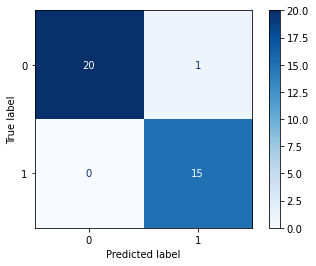

<Figure size 576x432 with 0 Axes>

In [241]:
evaluate_model(best_rf_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [242]:
cross_validation(best_rf_classifier_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [0.96551724 0.93103448 0.79310345 0.85714286 0.96428571]
Precision: [1.         0.86666667 0.71428571 0.8        0.93333333]
Recall: [0.9        1.         0.83333333 0.92307692 1.        ]
F1 Score: [0.94736842 0.92857143 0.76923077 0.85714286 0.96551724]
ROC AUC Score: [0.98421053 1.         0.95588235 0.94358974 1.        ]
Mean CV Accuracy: 0.9022167487684729
Mean CV Precision: 0.862857142857143
Mean CV Recall: 0.9312820512820513
Mean CV F1 Score: 0.8935661434753994
Mean CV ROC AUC Score: 0.9767365245693419


Decision Trees

In [243]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

Decision Trees for Women

In [244]:
dec_tree_classifier = DecisionTreeClassifier(random_state=15)

grid_search = GridSearchCV(estimator=dec_tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}


In [245]:
best_dec_tree_classifier_women = DecisionTreeClassifier(**best_params, random_state=15)
best_dec_tree_classifier_women.fit(X_train_val_women, y_train_val_women)

DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=4, min_samples_split=10,
                       random_state=15)

Evaluation metrics for women:
Accuracy: 0.7777777777777778
Precision: 0.8
Recall: 0.7058823529411765
F1 Score: 0.7500000000000001
ROC AUC Score: 0.7739938080495357


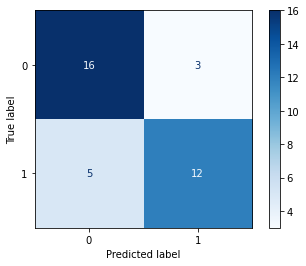

<Figure size 576x432 with 0 Axes>

In [246]:
evaluate_model(best_dec_tree_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [247]:
cross_validation(best_dec_tree_classifier_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.89655172 0.82142857 0.64285714 0.89285714 0.82142857]
Precision: [0.92857143 0.88888889 0.52380952 0.875      0.86666667]
Recall: [0.86666667 0.66666667 1.         0.93333333 0.8125    ]
F1 Score: [0.89655172 0.76190476 0.6875     0.90322581 0.83870968]
ROC AUC Score: [0.93095238 0.84114583 0.80748663 0.86666667 0.87760417]
Mean CV Accuracy: 0.8150246305418719
Mean CV Precision: 0.8165873015873016
Mean CV Recall: 0.8558333333333333
Mean CV F1 Score: 0.8175783939827321
Mean CV ROC AUC Score: 0.864771135727018


Decision Trees for Men

In [248]:
dec_tree_classifier = DecisionTreeClassifier(random_state=15)

grid_search = GridSearchCV(estimator=dec_tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


In [249]:
best_dec_tree_classifier_men = DecisionTreeClassifier(**best_params, random_state=15)
best_dec_tree_classifier_men.fit(X_train_val_men, y_train_val_men)

DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=5, random_state=15)

Evaluation metrics for men:
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.8666666666666667
F1 Score: 0.9285714285714286
ROC AUC Score: 0.9333333333333333


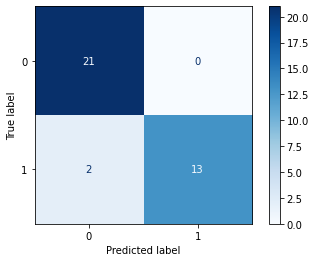

<Figure size 576x432 with 0 Axes>

In [250]:
evaluate_model(best_dec_tree_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [251]:
cross_validation(best_dec_tree_classifier_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [1.         0.86206897 0.96551724 0.85714286 0.96428571]
Precision: [1.         0.8        0.92307692 0.8        1.        ]
Recall: [1.         0.92307692 1.         0.92307692 0.92857143]
F1 Score: [1.         0.85714286 0.96       0.85714286 0.96296296]
ROC AUC Score: [1.         0.89903846 0.96813725 0.85641026 0.96428571]
Mean CV Accuracy: 0.9298029556650246
Mean CV Precision: 0.9046153846153846
Mean CV Recall: 0.9549450549450551
Mean CV F1 Score: 0.9274497354497354
Mean CV ROC AUC Score: 0.9375743374272785


Support Vector Machine (SVM)

In [252]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

SVM for Women

In [253]:
svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [254]:
best_svm_women = SVC(**best_params, random_state=15)
best_svm_women.fit(X_train_val_women, y_train_val_women)

SVC(C=1, gamma=0.001, random_state=15)

Evaluation metrics for women:
Accuracy: 0.9166666666666666
Precision: 0.9375
Recall: 0.8823529411764706
F1 Score: 0.9090909090909091
ROC AUC Score: 0.9148606811145512


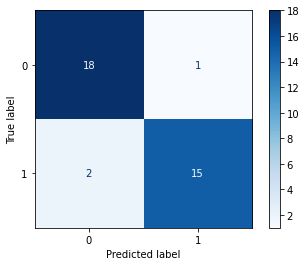

<Figure size 576x432 with 0 Axes>

In [255]:
evaluate_model(best_svm_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [256]:
cross_validation(best_svm_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.89655172 0.89285714 0.71428571 0.89285714 0.85714286]
Precision: [0.92857143 0.84615385 0.57894737 0.875      0.875     ]
Recall: [0.86666667 0.91666667 1.         0.93333333 0.875     ]
F1 Score: [0.89655172 0.88       0.73333333 0.90322581 0.875     ]
ROC AUC Score: [0.96190476 0.96354167 0.90374332 0.8974359  0.90625   ]
Mean CV Accuracy: 0.8507389162561576
Mean CV Precision: 0.8207345286292653
Mean CV Recall: 0.9183333333333333
Mean CV F1 Score: 0.8576221727845755
Mean CV ROC AUC Score: 0.9265751283030695


In [257]:
#perm_importance = permutation_importance(best_svm, X_train_women, y_train_women, n_repeats=10, random_state=15)
#feature_importance_scores = perm_importance.importances_mean
#for importance, feature in sorted(zip(feature_importance_scores, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

SVM for Men

In [258]:
svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}


In [259]:
best_svm_men = SVC(**best_params, random_state=15)
best_svm_men.fit(X_train_val_men, y_train_val_men)

SVC(C=0.1, gamma=0.01, kernel='poly', random_state=15)

Evaluation metrics for men:
Accuracy: 0.9722222222222222
Precision: 1.0
Recall: 0.9333333333333333
F1 Score: 0.9655172413793104
ROC AUC Score: 0.9666666666666667


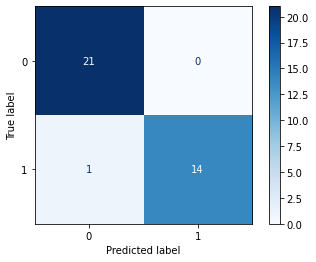

<Figure size 576x432 with 0 Axes>

In [260]:
evaluate_model(best_svm_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [261]:
cross_validation(best_svm_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [0.96551724 0.93103448 0.93103448 0.96428571 0.96428571]
Precision: [1.         0.86666667 0.85714286 0.92857143 1.        ]
Recall: [0.9        1.         1.         1.         0.92857143]
F1 Score: [0.94736842 0.92857143 0.92307692 0.96296296 0.96296296]
ROC AUC Score: [0.92631579 0.99519231 1.         0.96410256 1.        ]
Mean CV Accuracy: 0.951231527093596
Mean CV Precision: 0.9304761904761906
Mean CV Recall: 0.9657142857142856
Mean CV F1 Score: 0.9449885397253818
Mean CV ROC AUC Score: 0.9771221322537113


K-Nearest Neighbours

In [262]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],     
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

K-Nearest Neighbours for Women

In [263]:
knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}


In [264]:
best_knn_classifier_women = KNeighborsClassifier(**best_params)
best_knn_classifier_women.fit(X_train_val_women, y_train_val_women)

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

Evaluation metrics for women:
Accuracy: 0.8611111111111112
Precision: 0.875
Recall: 0.8235294117647058
F1 Score: 0.8484848484848485
ROC AUC Score: 0.8591331269349844


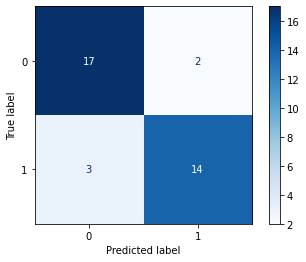

<Figure size 576x432 with 0 Axes>

In [265]:
evaluate_model(best_knn_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [266]:
cross_validation(best_knn_classifier_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.89655172 0.92857143 0.71428571 0.89285714 0.85714286]
Precision: [0.92857143 0.91666667 0.57894737 0.83333333 0.92857143]
Recall: [0.86666667 0.91666667 1.         1.         0.8125    ]
F1 Score: [0.89655172 0.91666667 0.73333333 0.90909091 0.86666667]
ROC AUC Score: [0.93809524 0.98697917 0.81283422 0.91794872 0.8828125 ]
Mean CV Accuracy: 0.8578817733990147
Mean CV Precision: 0.837218045112782
Mean CV Recall: 0.9191666666666667
Mean CV F1 Score: 0.8644618599791013
Mean CV ROC AUC Score: 0.9077339694619108


K-Nearest Neighbours for Men

In [267]:
knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [268]:
best_knn_classifier_men = KNeighborsClassifier(**best_params)
best_knn_classifier_men.fit(X_train_val_men, y_train_val_men)

KNeighborsClassifier(metric='manhattan', weights='distance')

Evaluation metrics for men:
Accuracy: 0.9166666666666666
Precision: 0.875
Recall: 0.9333333333333333
F1 Score: 0.9032258064516129
ROC AUC Score: 0.919047619047619


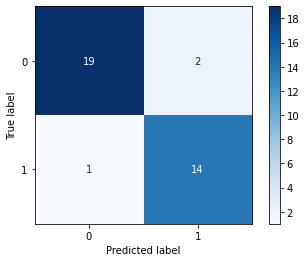

<Figure size 576x432 with 0 Axes>

In [269]:
evaluate_model(best_knn_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [270]:
cross_validation(best_knn_classifier_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [0.93103448 1.         0.93103448 0.96428571 0.96428571]
Precision: [0.9        1.         0.91666667 0.92857143 1.        ]
Recall: [0.9        1.         0.91666667 1.         0.92857143]
F1 Score: [0.9        1.         0.91666667 0.96296296 0.96296296]
ROC AUC Score: [0.98421053 1.         0.9754902  1.         1.        ]
Mean CV Accuracy: 0.958128078817734
Mean CV Precision: 0.949047619047619
Mean CV Recall: 0.949047619047619
Mean CV F1 Score: 0.9485185185185184
Mean CV ROC AUC Score: 0.9919401444788442
